In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import spacy
import torch
import torch.nn as nn
import torch.utils as utils
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import tokenizers
import matplotlib.pyplot as plt

from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Data

In [3]:
spacy_end = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_end.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
                    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [4]:
class FlickrDataset(utils.data.Dataset):
    def __init__(self, root_dir, captions_file, transform=None, mode='train', vocab=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.mode = mode
        
        train_df, temp_df = train_test_split(self.df, test_size=0.2, random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

        if self.mode == 'train':
            self.df = train_df
        elif self.mode == 'val':
            self.df = val_df
        else:
            self.df = test_df
            
        self.transform = transform
    
        # Get img, caption
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
    
        # Initialize vocabulary and build vocab
        if not vocab:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.captions.tolist())
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        caption = row["caption"]
        img_id = row["image"]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption), img_id

In [5]:
class Collate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        img_ids = [item[2] for item in batch]
        
        return imgs, targets, img_ids

In [6]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
):
    train_dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    shared_vocab = train_dataset.vocab
    val_dataset = FlickrDataset(root_folder, annotation_file, transform=transform, mode='val', vocab=shared_vocab)
    test_dataset = FlickrDataset(root_folder, annotation_file, transform=transform, mode='test', vocab=shared_vocab)
    pad_idx = train_dataset.vocab.stoi["<PAD>"]

    train_loader = utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    val_loader = utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    test_loader = utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=1,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=Collate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, test_loader, train_dataset

# Encoder

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(weights='DEFAULT', aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        try:
            features, _ = self.inception(images)
        except ValueError:
            features = self.inception(images)

        for name, param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN

        return self.dropout(self.relu(features))

# Decoder

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# Model

In [9]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
        
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                # temperature = 1.0
                # probs = torch.softmax(output / temperature, dim=1)
                # predicted = torch.multinomial(probs, 1).squeeze(0)
                
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
  
        return [vocabulary.itos[idx] for idx in result_caption]

# Training

In [10]:
# A captions dictionary to get reference captions for BLEU score
class CaptionsDict():
    def __init__(self):
        self.captions_dict = {}

    def get_captions_dict(self, captions_file):
        with open(captions_file) as f:
            next(f)
            for line in f:
                
                img_id, captions = line.split(',', 1)
                captions = captions.split()
                
                if img_id in self.captions_dict.keys():
                    self.captions_dict[img_id].append(captions)
                else:
                    self.captions_dict[img_id] = [captions]

    def get_reference_captions(self, img_id):
        return self.captions_dict[img_id]

In [11]:
def test(model, criterion, loader, device):
    model.eval()
    total_loss = 0
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])

    # Testing
    for imgs, captions, _ in loader:
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        total_loss += loss.item()
        
    print(f"Val Loss: {total_loss / len(loader)}")
    
    # Print an example
    img = imgs[0]
    
    generated_caption = model.caption_image(img.unsqueeze(0), train_dataset.vocab)

    display_img = img.cpu()
    display_img = display_img * std[:, None, None] + mean[:, None, None]
    
    plt.imshow(display_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(' '.join(generated_caption), fontsize=10)
    plt.show()

In [12]:
from tqdm import tqdm

def train(train_loader, vocab, val_loader=None, test_loader=None, load_model=False, save_model=False):
    captions_dict = CaptionsDict()
    captions_dict.get_captions_dict("/kaggle/input/flickr8k/captions.txt")

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(train_dataset.vocab)
    num_layers = 1
    learning_rate = 1e-3
    num_epochs = 15

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if load_model:
        checkpoint = torch.load('/kaggle/working/checkpoint.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        pbar = tqdm(train_loader)
        for imgs, captions, _ in pbar:
            pbar.set_description(f"Epoch {epoch}")
            
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
                
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Train Loss: {epoch_loss/len(train_loader)}")
        
        if val_loader:
            val_loss = test(model, criterion, val_loader, device)

        if save_model:
            checkpoint = torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss/len(train_loader),
            }, 'checkpoint_greedy.pth')

In [13]:
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader, val_loader, test_loader, train_dataset = get_loader(
    root_folder = "/kaggle/input/flickr8k/Images",
    annotation_file = "/kaggle/input/flickr8k/captions.txt",
    transform = transform,
    num_workers = 2,
)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 171MB/s] 
Epoch 0: 100%|██████████| 1012/1012 [03:20<00:00,  5.04it/s]

Train Loss: 3.4504572252039853


Val Loss: 2.9934494439072497


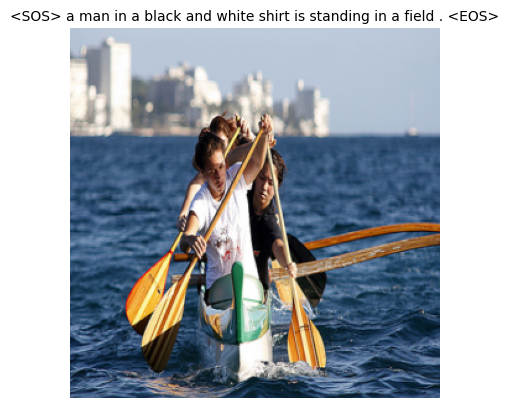

Epoch 1: 100%|██████████| 1012/1012 [02:48<00:00,  6.00it/s]

Train Loss: 2.9289347929916834


Val Loss: 2.7895176072758954


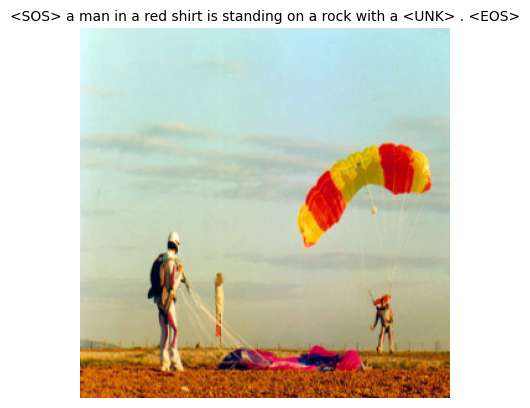

Epoch 2: 100%|██████████| 1012/1012 [02:47<00:00,  6.02it/s]

Train Loss: 2.7478215800443655


Val Loss: 2.6725965240808924


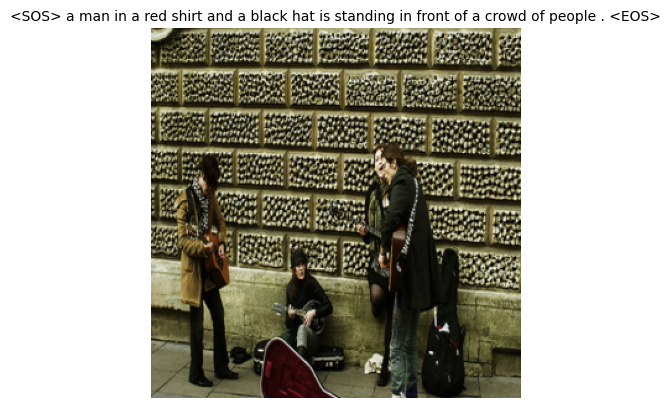

Epoch 3: 100%|██████████| 1012/1012 [02:47<00:00,  6.02it/s]

Train Loss: 2.6288314673740403


Val Loss: 2.5991042148409864


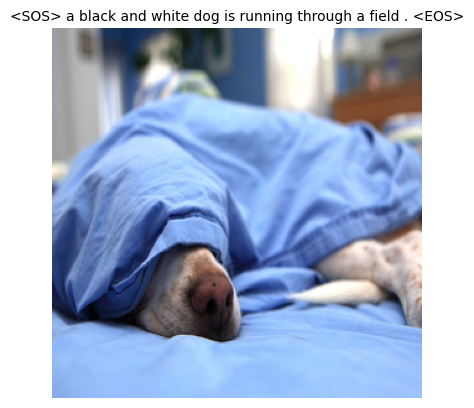

Epoch 4: 100%|██████████| 1012/1012 [02:48<00:00,  6.00it/s]

Train Loss: 2.5433453281406355


Val Loss: 2.5525422659445933


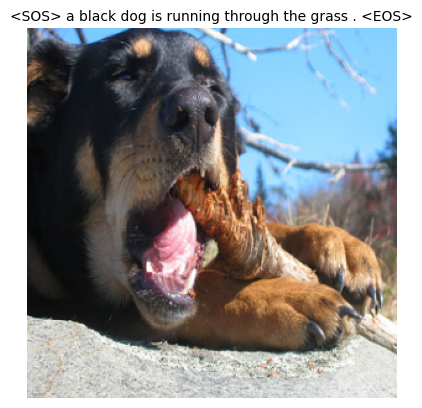

Epoch 5: 100%|██████████| 1012/1012 [02:49<00:00,  5.98it/s]

Train Loss: 2.4786790713019995


Val Loss: 2.5133529535428747


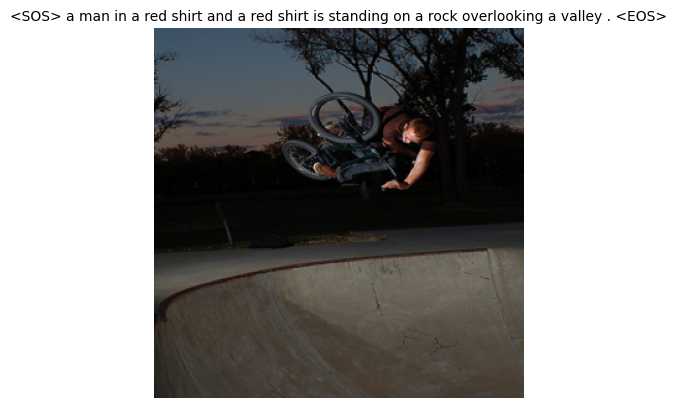

Epoch 6: 100%|██████████| 1012/1012 [02:48<00:00,  6.00it/s]

Train Loss: 2.4274532816155627


Val Loss: 2.489653416505949


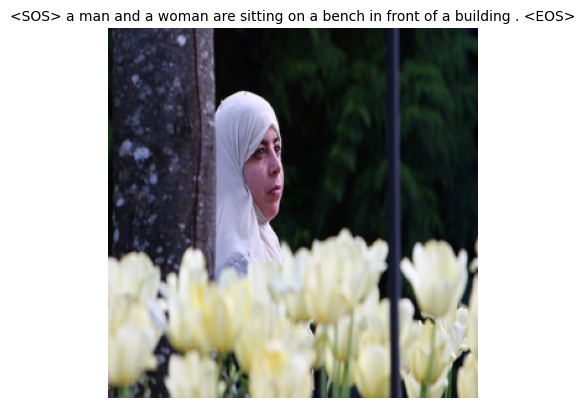

Epoch 7: 100%|██████████| 1012/1012 [02:49<00:00,  5.97it/s]

Train Loss: 2.383012475703545


Val Loss: 2.4723464203631784


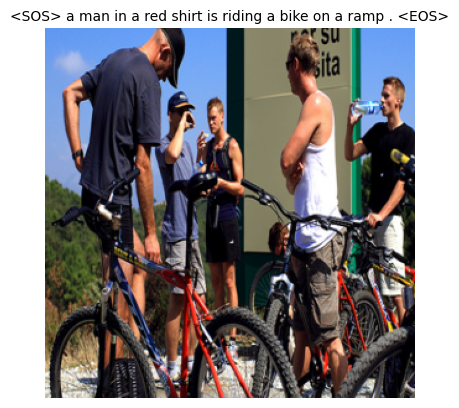

Epoch 8: 100%|██████████| 1012/1012 [02:47<00:00,  6.02it/s]

Train Loss: 2.346829664094646


Val Loss: 2.453165496428182


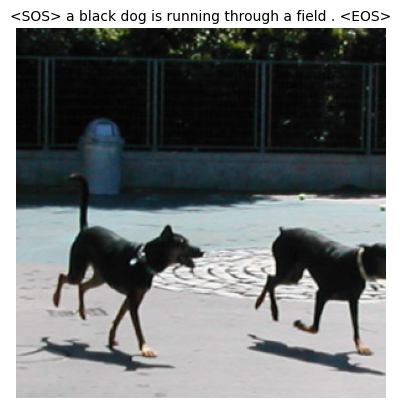

Epoch 9: 100%|██████████| 1012/1012 [02:48<00:00,  6.02it/s]

Train Loss: 2.313311559409492


Val Loss: 2.44922527178066


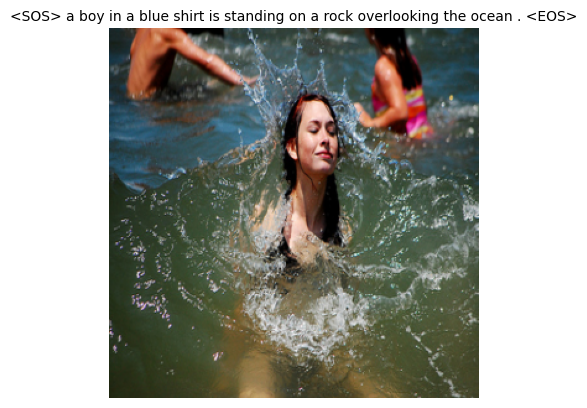

Epoch 10: 100%|██████████| 1012/1012 [02:47<00:00,  6.04it/s]

Train Loss: 2.285225432498653


Val Loss: 2.43803940795538


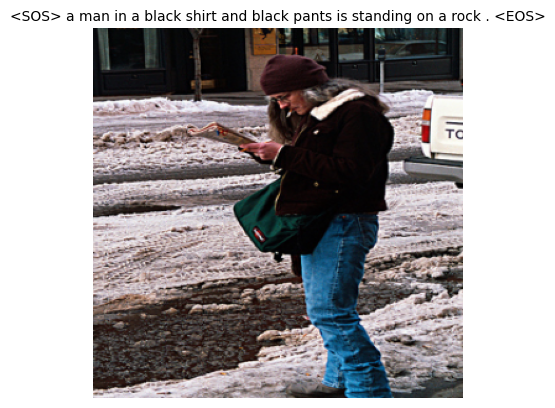

Epoch 11: 100%|██████████| 1012/1012 [02:47<00:00,  6.04it/s]

Train Loss: 2.2611212779881926


Val Loss: 2.43861599794523


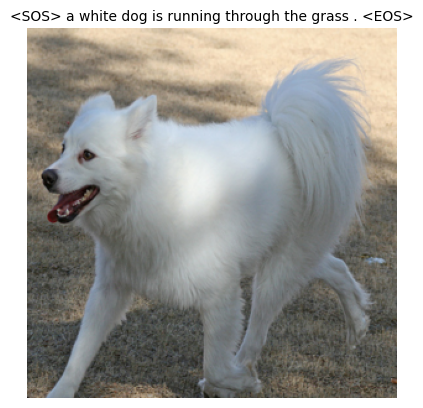

Epoch 12: 100%|██████████| 1012/1012 [02:47<00:00,  6.04it/s]

Train Loss: 2.2380903340846654


Val Loss: 2.4287299340165505


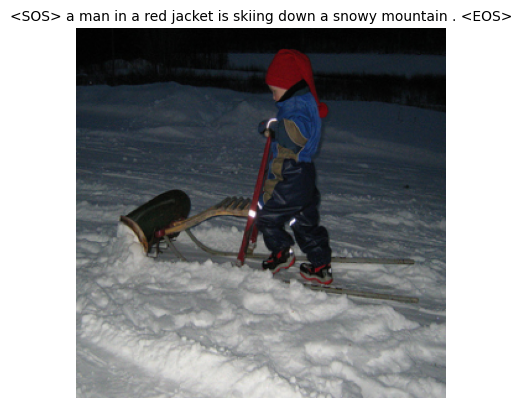

Epoch 13: 100%|██████████| 1012/1012 [02:46<00:00,  6.09it/s]

Train Loss: 2.216050552756419


Val Loss: 2.4260584763654576


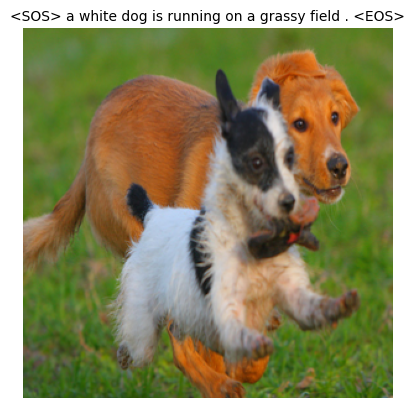

Epoch 14: 100%|██████████| 1012/1012 [02:44<00:00,  6.14it/s]

Train Loss: 2.196323879151476


Val Loss: 2.4273011684417725


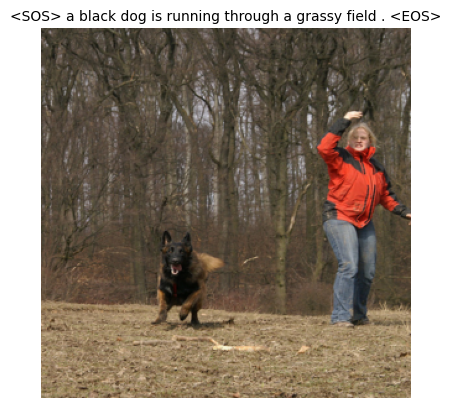

In [14]:
train(train_loader, train_dataset.vocab, val_loader, test_loader, load_model=False, save_model=True)

# Testing

In [26]:
# Parameters
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers)

# Load model
checkpoint = torch.load('/kaggle/working/checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

captions_dict = CaptionsDict()
captions_dict.get_captions_dict("/kaggle/input/flickr8k/captions.txt")

# Testing using BLEU score
reference_captions = []
generated_captions = []

for imgs, captions, img_id in tqdm(test_loader):
    img = imgs.to(device)
    
    generated_caption = model.caption_image(img, train_dataset.vocab)[1:-1]
    
    reference_captions.append(captions_dict.get_reference_captions(img_id[0]))
    generated_captions.append(generated_caption)
    
# Calculating BLEU Score
smooth_fn = SmoothingFunction().method4
bleu = corpus_bleu(reference_captions, generated_captions, smoothing_function=smooth_fn)
print(f"BLEU Score: {bleu}")

100%|██████████| 4046/4046 [02:14<00:00, 30.03it/s]


BLEU Score: 0.11176365064097767


# Inference

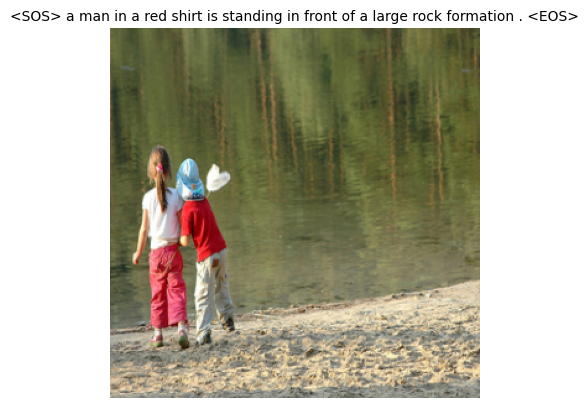

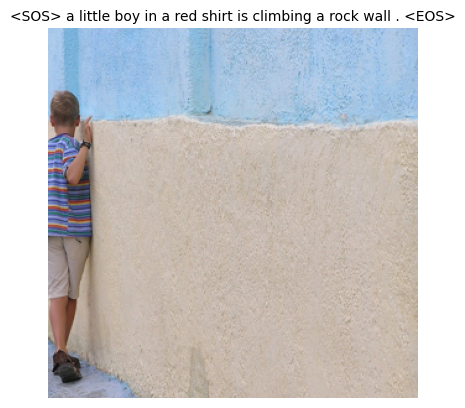

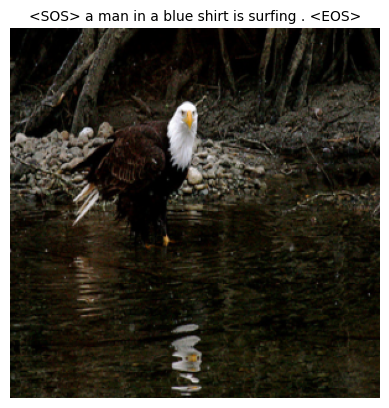

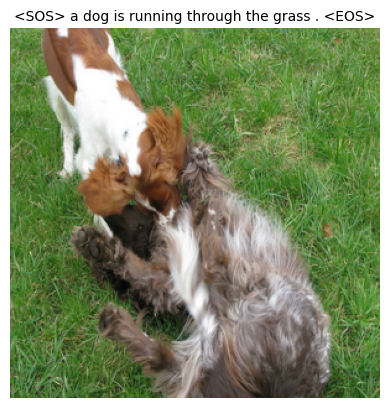

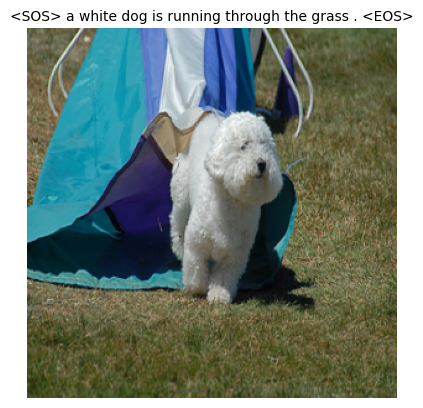

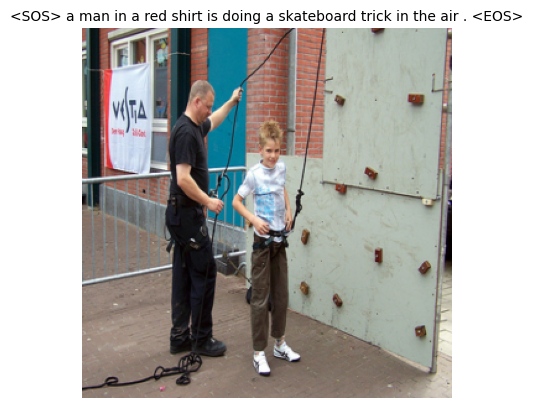

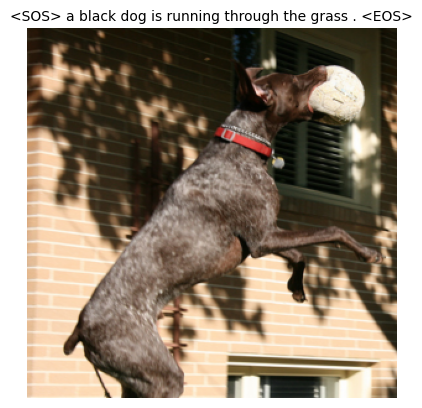

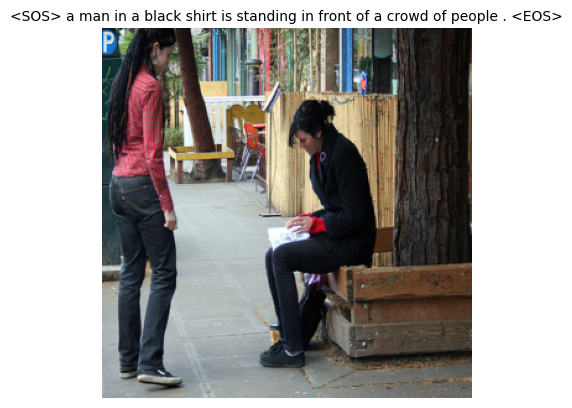

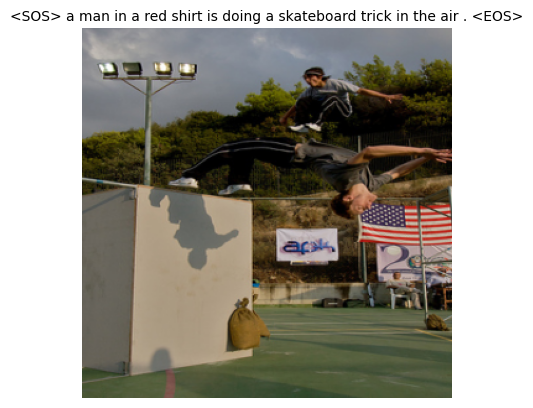

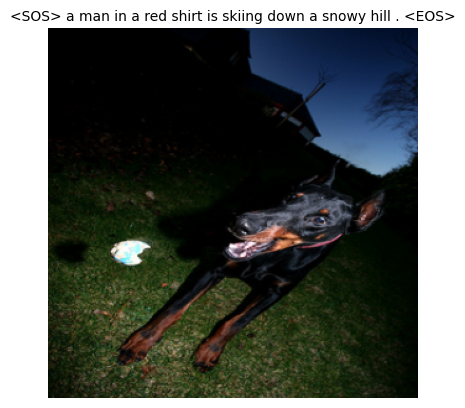

In [17]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

for i, (imgs, captions, img_id) in enumerate(test_loader):
    if i < 10:
        img = imgs.to(device)
    
        generated_caption = model.caption_image(img, train_dataset.vocab)
    
        display_img = img[0].cpu()
        display_img = display_img * std[:, None, None] + mean[:, None, None]
        
        plt.imshow(display_img.permute(1, 2, 0))
        plt.axis('off')
        plt.title(' '.join(generated_caption), fontsize=10)
        plt.show()
    else:
        break